# Cross Sections and Vectors - Ocean Temperature and Surface Wind

This notebook covers:
* How to plot a cross section of temperature data through the Tasman Sea.
* How to plot vectors showing the wind direction and magnitude.


In [1]:
import accessvis
import numpy as np
from tqdm.notebook import tqdm
import xarray as xr
import pandas as pd


Loading the datasets:
* thetao - Ocean temperature at different depths 
* uas - eastward wind speed at the surface
* vas - northward wind speed at the surface

In [ ]:
thetao=xr.open_dataset("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/thetao/gn/latest/thetao_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_201001-201412.nc")
uas=xr.open_dataset("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/uas/gn/latest/uas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc")
vas=xr.open_dataset("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/vas/gn/latest/vas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc")


### Setting up the Earth
* We put bathymetry on so we can see the ocean floor.
* We exaggerate the vertical height - The earth is too big

In [3]:
vertical_exaggeration=200 # How much should the ocean 
lv = accessvis.plot_earth(bathymetry=True, lighting=False, texture='relief', vertical_exaggeration=vertical_exaggeration)  

# Moving the camera to the desired location.
lv.translation(0.425, -4.865, -7.104)
lv.rotation(-87.602, -7.699, 165.763)


### Choosing Start/End Locations
We choose to go from (40S, 150E) to (40S, 165E).

In [4]:
# The data provided is indexed by coordinates i,j (not lat/lon) because it is on a tripolar grid.
# The following function finds the (i,j) pair closest to provided lat/lon.

def nearest_lat_lon(lat, lon):    
    lats = thetao.latitude
    lons = thetao.longitude

    # Compute squared distance (Haversine optional for geographic accuracy)
    delta = np.sqrt((lats - lat)**2 + (lons - lon)**2)

    # Find the indices of the minimum distance
    min_idx = delta.argmin(dim=["i", "j"])
    i = min_idx["i"].to_numpy()
    j = min_idx["j"].to_numpy()
    return {
        "i": i,
        "j": j,
        # "lat": u.latitude.sel(i=i,j=j).to_numpy(),
        # "lon": u.longitude.sel(i=i,j=j).to_numpy(),
    }
print(nearest_lat_lon(0, 115)) # example lat/lon

{'i': array(34), 'j': array(136)}


In [5]:
example_time = thetao.time.to_numpy()[-1]
lat = -40
start_lon = 150
end_lon = 165
num_arrows=9
# Calculating the nearest i,j to the lat lon start/finish.
# Note - j is constant because we are not plotting near the poles.
start_i = int(nearest_lat_lon(lat, start_lon)['i']) 
end_i = int(nearest_lat_lon(lat, end_lon)['i'])
j = int(nearest_lat_lon(lat, start_lon)['j'])


### Adding Wind Vectors
`vector_coords` is a list of xarray coordinates. Here we are creating `num_arrows` vectors.

`accessvis.plot_vectors_xr` is able to get the vector components using the provided coordinates and adds them to the Earth.


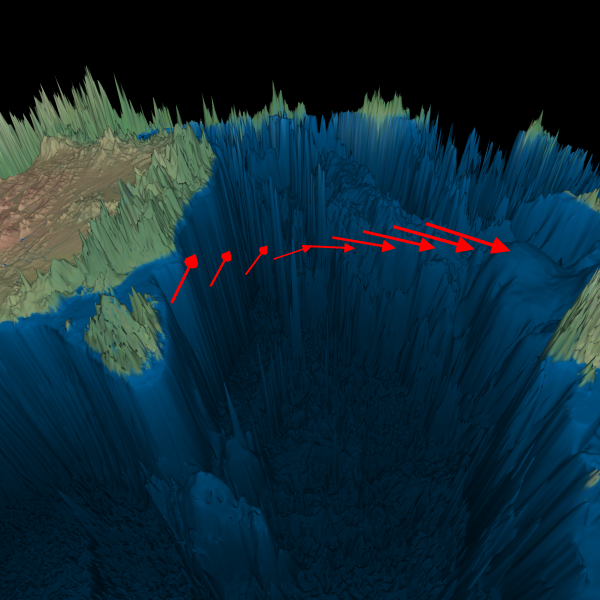

In [6]:
vector_coords = [{
    'time':example_time, 
    'lat':lat,
    'lon':lon,
} for lon in np.linspace(start_lon, end_lon, num_arrows)]

accessvis.plot_vectors_xr(lv, vector_coords, u=uas['uas'], v=vas['vas'], 
                          alt_scale_factor=0, # putting vectors on ground level 
                          scalevectors=0.4) # making the vectors smaller

lv.display((600,600))

### Adding the Temperature Cross Section

We create a numpy array of the data to display. `accessvis.array_to_rgba()` is used to colourise the data.

We define start and end points (lon, lat, depth). Note that depth is in units of million meters. 
Previously we exaggerated the vertical height to make the oceans deeper. We scale the end depth by the same amount.

NOTE: The thetao.lev (depth) coordinates are not regularly spaced. Near the surface they are 10m apart, at the bottom of the ocean they are 300m apart. We are ignoring this here, which causes to the top of the ocean to be larger.


In [7]:
try:
    # If this cell is run multiple times, it will create a new cross section each time unless cleared.
    cross_section.clear()
except NameError:
    pass

raw_temp = thetao.sel(time=example_time, j=j, i=slice(start_i, end_i))['thetao'].to_numpy() # select the data
colours = accessvis.array_to_rgba(raw_temp, maximum=18, minimum=0) # make it pretty

# Above we 
max_depth = -1 * float(np.max(thetao.lev)) * vertical_exaggeration / 1e6 #~6000m below sea level, after exaggeration
start = (start_lon, lat, 0) # it starts at the surface
end = (end_lon, lat, max_depth)

cross_section = accessvis.plot_cross_section(lv, colours, start=start, end=end) # add to lavavu.


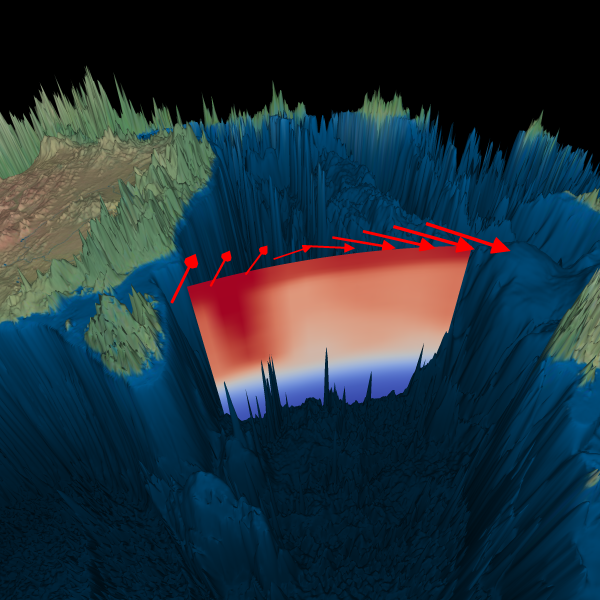

In [8]:
lv.display((600,600))

# lv.window((600,600)) # run this instead to make it interactive.


## Animation

We add a title, and a dial in the corner displaying the time of year.

In [9]:
lv.title(f'Wind Speed and Ocean Temperature', fontsize=100)
wid = accessvis.CalendarWidget(lv=lv, text_colour = 'white', scale=0.2, offset=(0,0))


Output #0, mp4, to 'temp-wind.mp4':
  Stream #0:0: Unknown: none


  0%|          | 0/60 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

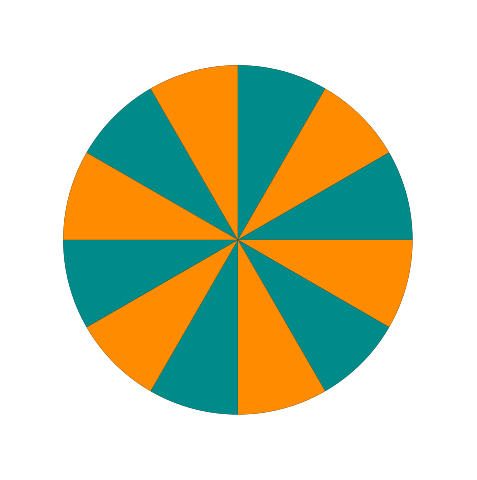

In [10]:
with lv.video(filename='temp-wind.mp4', quality=2, resolution=(600,600), width=600, height=600, fps=12) as v:
    for time in tqdm(thetao.time.values): 
        # Creating one frame per time step.

        # update the dial to show the correct time
        wid.update_widget(date=pd.to_datetime(time).to_pydatetime())
        
        # Updating the vectors
        vector_coords = [{
            'time':time,
            'lat':lat,
            'lon':lon,
        } for lon in np.linspace(start_lon, end_lon, num_arrows)]
        vec = accessvis.plot_vectors_xr(lv, vector_coords, u=uas['uas'], v=vas['vas'], alt_scale_factor=0)

        # Updating the cross section
        raw_temp = thetao.sel(time=time, j=j, i=slice(start_i, end_i))['thetao'].to_numpy()
        colours = accessvis.array_to_rgba(raw_temp, maximum=18, minimum=0)
        # Note that we don't run `accessvis.plot_cross_section` again. We update the existing object.
        cross_section.texture(colours)

        # create the next frame of the animation.
        lv.render()
